In [187]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Generate Marks and Assign Result

In [188]:
mean = 50
stDev = 15

In [189]:
marks = np.random.normal(mean, stDev, size=(100000, 10))
marks = np.clip(marks, 5, 95)
result = np.random.randint(2, size=(100000))

In [190]:
marks.shape, result.shape

((100000, 10), (100000,))

In [191]:
np.min(marks), np.max(marks)

(5.0, 95.0)

In [192]:
df = pd.DataFrame(marks, columns=[f'SUB-{i+1}' for i in range(10)])
df['Result'] = result
df.head()

,SUB-1,SUB-2,SUB-3,SUB-4,SUB-5,SUB-6,SUB-7,SUB-8,SUB-9,SUB-10,Result
0,24.328256,49.104069,22.554952,59.648705,33.520150,69.531124,15.697901,45.863868,75.405247,53.383720,0
1,35.239132,48.993654,42.153146,66.161263,8.183794,42.870676,65.916186,63.496605,33.762981,36.461425,1
2,61.458363,49.945826,69.434075,45.316829,67.722166,44.675764,72.150016,45.061484,64.992891,5.000000,0
3,28.071520,67.610544,36.885702,60.430747,70.886357,51.740526,61.313752,56.044753,43.379888,69.263713,1
4,62.830852,37.707610,30.417489,51.371803,42.985614,77.102102,51.825320,59.452192,37.866813,63.819147,1


In [193]:
df.sample(5)

,SUB-1,SUB-2,SUB-3,SUB-4,SUB-5,SUB-6,SUB-7,SUB-8,SUB-9,SUB-10,Result
69134,60.015475,63.429802,38.926476,56.364478,37.726260,18.676558,32.964650,53.531267,64.695141,46.256166,0
77694,69.126328,62.166429,45.269669,84.650568,38.374097,37.890637,53.023010,57.927598,64.800639,41.001380,0
45251,42.367675,58.777269,38.356208,50.502432,61.272950,49.277710,49.889107,51.895206,49.242860,66.713753,0
45992,57.828583,59.897135,63.190318,61.043190,38.853604,50.288923,56.193317,42.440606,42.128047,61.564405,0
47236,55.831676,32.429914,19.708527,58.836030,45.382154,58.018882,60.789810,67.227400,38.973848,28.274210,1


In [194]:
df['Result'].value_counts()

Result
0    50318
1    49682
Name: count, dtype: int64

### 2. Plot histogram of each subject

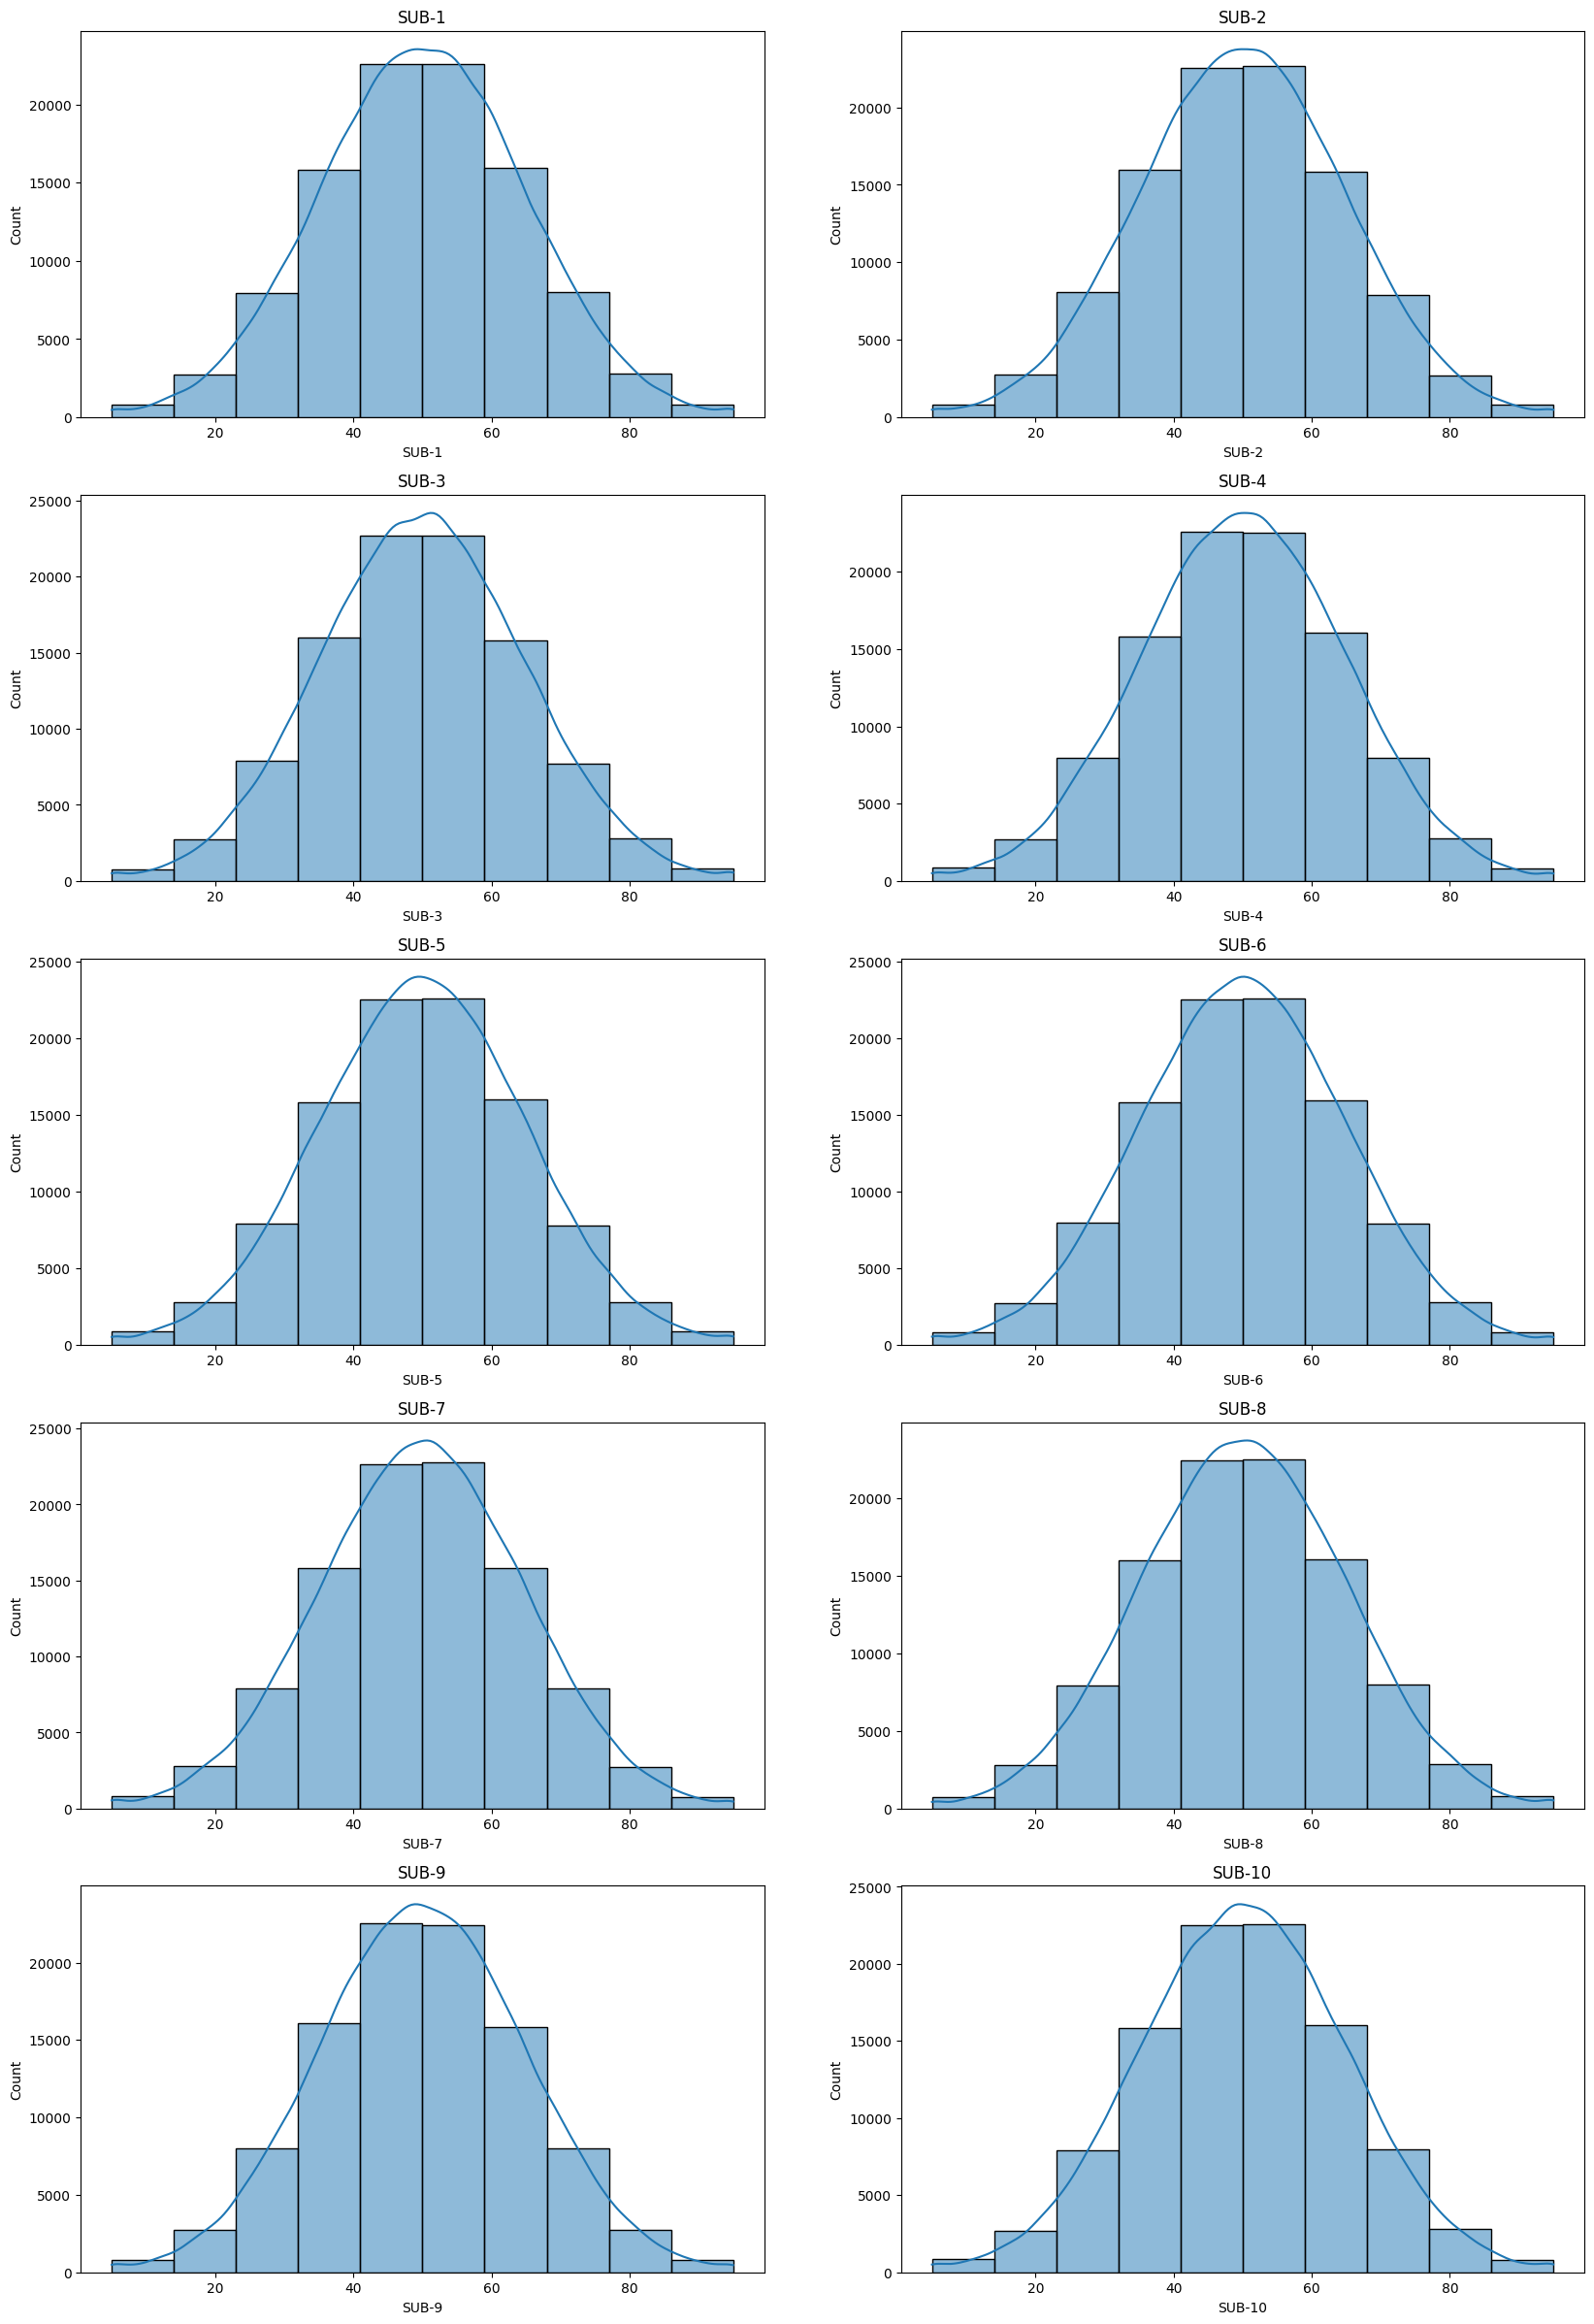

In [195]:
plt.figure(figsize=(20, 30))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.title(f'SUB-{i+1}')
    sns.histplot(df[f'SUB-{i+1}'], kde=True, bins=10)
plt.show()    

### 3. ANN Model

In [196]:
X = df.iloc[:, :10].values.reshape(10, 100000)
y = df.iloc[:, -1].values.reshape(1, 100000)

In [197]:
X.shape, y.shape

((10, 100000), (1, 100000))

In [198]:
xTrain, xTest = X[:, :80000], X[:, 80000:]
yTrain, yTest = y[:, :80000], y[:, 80000:]

In [199]:
xTrain.shape, yTrain.shape

((10, 80000), (1, 80000))

In [200]:
xTest.shape, yTest.shape

((10, 20000), (1, 20000))

In [201]:
def sigmoid(z):
    # z = np.clip(z, -88.72, 88.72)
    return 1 / (1 + np.exp(-z))

def relu(z, dvt=False):
    if dvt:
        return 1. * (z > 0)
    return np.maximum(0, z)

In [202]:
def initializeParameters(ldims):
    L = len(ldims)
    params = {}
    for i in range(1, L):
        params[f'W{i}'] = np.random.randn(ldims[i], ldims[i-1]) / np.sqrt(ldims[i-1])
        params[f'b{i}'] = np.random.randn(ldims[i], 1)
    return params

In [203]:
def forwardPropagation(X, params):
    L = len(params) // 2
    cache = {}
    cache[f'A0'] = X
    for i in range(1, L):
        cache[f'Z{i}'] = np.dot(params[f'W{i}'], cache[f'A{i-1}']) + params[f'b{i}']
        cache[f'A{i}'] = relu(cache[f'Z{i}'])
    cache[f'Z{L}'] = np.dot(params[f'W{L}'], cache[f'A{L-1}']) + params[f'b{L}']
    cache[f'A{L}'] = sigmoid(cache[f'Z{L}'])

    return cache[f'A{L}'], cache

In [204]:
def costFunction(y, A):
    m = y.shape[1]
    cost = 1./m * (-np.dot(y, np.log(A).T) - np.dot((1 - y), np.log(1 - A).T))
    return np.squeeze(cost)

In [205]:
def backwardPropagation(A, y, params, cache):
    grads = {}
    L = len(params) // 2
    m = y.shape[1]
    
    grads[f'dZ{L}'] = A - y
    grads[f'dW{L}'] = 1./m * np.dot(grads[f'dZ{L}'], cache[f'A{L-1}'].T)
    grads[f'db{L}'] = 1./m * np.sum(grads[f'dZ{L}'], axis = 1, keepdims = True)
    
    for i in reversed(range(1, L)):
        grads[f'dZ{i}'] = np.dot(params[f'W{i+1}'].T, grads[f'dZ{i+1}']) * relu(cache[f'A{i}'], True)
        grads[f'dW{i}'] = 1./m * np.dot(grads[f'dZ{i}'], cache[f'A{i-1}'].T)
        grads[f'db{i}'] = 1./m * np.sum(grads[f'dZ{i}'], axis = 1, keepdims = True)
    return grads

In [206]:
def updateParameters(params, grads, lr):
    L = len(params) // 2
    for i in range(L):
        params[f'W{i+1}'] -= lr * grads[f'dW{i+1}']
        params[f'b{i+1}'] -= lr * grads[f'db{i+1}']
    return params

In [207]:
def predict(X, params):
    yPred, _ = forwardPropagation(X, params)
    yPred = 1. * (yPred > 0.5)
    return yPred

In [208]:
dims = [xTrain.shape[0], 15, 15, 15, yTrain.shape[0]]
params = initializeParameters(dims)
epocs = 100
lr = 0.1

time = []
cost = []
accuracy = []

for i in range(epocs):
    AL, cache = forwardPropagation(xTrain, params)
    if i % (epocs/10) == 0:
        time.append(i)
        cost.append(costFunction(yTrain, AL))
        accuracy.append(np.sum(predict(xTrain, params) == yTrain)/yTrain.shape[1])

    grads = backwardPropagation(AL, yTrain, params, cache)
    params = updateParameters(params, grads, lr)

C:\Users\shubh\AppData\Local\Temp\ipykernel_244\1315521246.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


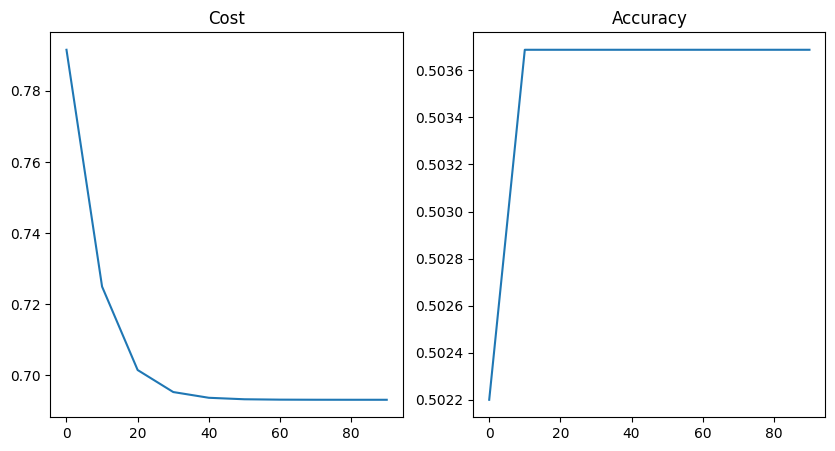

In [209]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Cost')
plt.plot(time, cost)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(time, accuracy)
plt.show()

In [210]:
# training accuracy
predTrain = predict(xTrain, params)
np.sum(predTrain == yTrain)/yTrain.shape[1]

0.5036875

In [211]:
# testing accuracy
predTest = predict(xTest, params)
np.sum(predTest == yTest)/yTest.shape[1]

0.50115